In [67]:
#general imports
import pandas as pd
import numpy as np

#statsmodels for regression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

#scipy for testing
from scipy import stats

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta

In [68]:
##Bike Data

In [69]:
df_bikes = pd.read_csv('../data/philadelphia_2017.csv')
df_weather = pd.read_csv('../data/weather_hourly_philadelphia.csv')

df_bikes.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
0,1/1/2017 0:05,1/1/2017 0:16,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL"
1,1/1/2017 0:21,1/1/2017 0:57,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum
2,1/1/2017 0:22,1/1/2017 0:57,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum
3,1/1/2017 0:27,1/1/2017 0:39,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS"
4,1/1/2017 0:28,1/1/2017 0:36,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier


In [70]:
df_bikes.describe()

,start_station_id,end_station_id,bike_id
count,788907.000000,788907.000000,788907.000000
mean,3057.400081,3056.431487,5428.980913
std,41.126829,41.108792,3221.972215
min,3000.000000,3000.000000,0.000000
25%,3023.000000,3023.000000,3350.000000
50%,3050.000000,3049.000000,3703.000000
75%,3075.000000,3074.000000,5370.000000
max,3170.000000,3170.000000,11965.000000


In [71]:
##Weather Data

In [72]:
df_weather.head()

,date_time,max_temp,min_temp,precip
0,2015-01-02 01:00:00,3.3,3.3,0.0
1,2015-01-02 02:00:00,2.8,2.8,0.0
2,2015-01-02 03:00:00,2.2,2.2,0.0
3,2015-01-02 04:00:00,0.6,0.6,0.0
4,2015-01-02 05:00:00,1.1,1.1,0.0


In [73]:
df_weather.describe()

,max_temp,min_temp,precip
count,43785.000000,43785.000000,43785.000000
mean,14.204796,14.121300,0.087770
std,10.272673,10.259344,0.282963
min,-16.700000,-16.700000,0.000000
25%,6.100000,6.100000,0.000000
50%,15.000000,14.400000,0.000000
75%,22.800000,22.800000,0.000000
max,36.700000,36.700000,1.000000


In [74]:
# start and end time transformed to datetime and added duration from start till the end of the loan
df_bikes["start_time"] = pd.to_datetime(df_bikes["start_time"], dayfirst = True)

df_bikes["end_time"] = pd.to_datetime(df_bikes["end_time"], dayfirst = True)

df_bikes['duration'] = df_bikes['end_time'] - df_bikes['start_time']

df_bikes['weekday'] = df_bikes["start_time"].apply(lambda x: x.weekday())


#checks whether the weekday is a day in the week(1) or in weekend(0)
def is_weekday(day):
    if day == 5 or day == 6:
        return 0
    else:
        return 1


df_bikes['is_weekday'] = df_bikes['weekday'].apply(lambda x: is_weekday(x))

df_bikes.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,weekday,is_weekday
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",0 days 00:11:00,6,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,0 days 00:36:00,6,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,0 days 00:35:00,6,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",0 days 00:12:00,6,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,0 days 00:08:00,6,0


In [75]:
ride_lengths = []

for label, content in df_bikes.iterrows():
    ride_lengths.append(content['duration'])

In [76]:

ride_lengths_np = np.array(ride_lengths)
iqr = stats.iqr(ride_lengths_np)
iqr

q1,q3 = np.percentile(ride_lengths_np, [25,95])

lower_range = q1 - (1.5*iqr)
upper_range = q3 + (1.5*iqr)


minutes_0 = timedelta(minutes=0)

#A ride, can't be shorter than 0 Minutes obviously
if lower_range < minutes_0:
    lower_range = minutes_0

df_bikes.drop(df_bikes[ (df_bikes['duration'].apply(lambda x: x) > upper_range) | (df_bikes['duration'].apply(lambda x: x) < lower_range) ].index , inplace=True)

In [77]:
print(len(df_bikes))

763125


In [78]:

unique_station_ids = set(df_bikes['start_station_id'])
id_mapped_to_station = []
for id in unique_station_ids:
    this_station = []
    this_station.append(id)
    this_station.append(df_bikes.loc[df_bikes['start_station_id'] == id].iloc[0]['start_station_name'])
    id_mapped_to_station.append(this_station)
print(id_mapped_to_station)

[[3072, 'Front & Carpenter'], [3073, '9th & Spring Garden'], [3074, '44th & Walnut'], [3075, 'Fairmount & Ridge'], [3077, '17th & Girard'], [3078, '19th & Market'], [3083, '3083'], [3086, 'Broad & Christian'], [3088, '3rd & Girard'], [3093, '33rd & Diamond'], [3095, '29th & Diamond'], [3096, '29th & Dauphin'], [3097, 'Berks Station, MFL'], [3098, '10th & Federal'], [3099, '4th & Washington'], [3100, 'Moyamensing & Tasker'], [3101, '11th & South'], [3102, 'Pennsylvania & Fairmount Perelman Building'], [3103, '27th & Master, Athletic Recreation Center'], [3104, '34th & Mantua'], [3105, 'Penn Treaty Park'], [3106, '33rd & Dauphin'], [3107, '33rd & Reservoir'], [3108, '15th & Market'], [3109, 'Parkside & Girard'], [3110, 'Del. River Trail & Penn St.'], [3111, 'Parkside & Belmont, Case Building'], [3112, '48th & Spruce'], [3113, 'Philadelphia Zoo'], [3114, '22nd & Federal'], [3115, '19th & Girard, PTTI'], [3116, 'Barnes Foundation'], [3117, 'ParkWest Town Center'], [3118, '46th Street Stati

In [79]:

# das noch mit den IDs oder Namen der Stations matchen
starting_id_loans = []
for id in unique_station_ids:
    starting_id_loans.append(sum(1 for i in df_bikes['start_station_id'] if i == id))
print(starting_id_loans)

[4543, 5952, 5227, 5291, 2162, 10625, 9, 5509, 2685, 705, 1447, 875, 2437, 4622, 4252, 6365, 13479, 11136, 1018, 1773, 1098, 1060, 1299, 12560, 1336, 3281, 1593, 4711, 822, 6358, 3096, 48, 823, 2406, 1999, 5249, 5487, 790, 1290, 4908, 9956, 4014, 1605, 748, 1440, 3386, 1243, 5579, 2174, 2767, 3990, 2720, 4390, 3607, 4428, 570, 925, 130, 936, 3557, 102, 8679, 4488, 7544, 11808, 2896, 11126, 23158, 4145, 15072, 4813, 1818, 6378, 715, 1365, 11109, 3966, 15798, 19271, 14057, 23863, 4822, 6509, 8228, 4452, 12488, 11313, 8844, 5874, 15866, 8302, 7737, 5327, 2693, 6470, 9906, 4959, 9756, 4188, 5148, 18627, 9024, 8620, 5294, 7260, 8967, 11992, 7706, 15773, 5984, 8660, 12505, 9599, 7863, 8079, 9857, 6305, 12549, 9044, 1375, 10580, 696, 7561, 6234, 5213, 4214]


In [80]:

# das noch mit den IDs oder Namen der Stations matchen
ending_id_loans = []
for id in unique_station_ids:
    ending_id_loans.append(sum(1 for i in df_bikes['end_station_id'] if i == id))
print(starting_id_loans)

[4543, 5952, 5227, 5291, 2162, 10625, 9, 5509, 2685, 705, 1447, 875, 2437, 4622, 4252, 6365, 13479, 11136, 1018, 1773, 1098, 1060, 1299, 12560, 1336, 3281, 1593, 4711, 822, 6358, 3096, 48, 823, 2406, 1999, 5249, 5487, 790, 1290, 4908, 9956, 4014, 1605, 748, 1440, 3386, 1243, 5579, 2174, 2767, 3990, 2720, 4390, 3607, 4428, 570, 925, 130, 936, 3557, 102, 8679, 4488, 7544, 11808, 2896, 11126, 23158, 4145, 15072, 4813, 1818, 6378, 715, 1365, 11109, 3966, 15798, 19271, 14057, 23863, 4822, 6509, 8228, 4452, 12488, 11313, 8844, 5874, 15866, 8302, 7737, 5327, 2693, 6470, 9906, 4959, 9756, 4188, 5148, 18627, 9024, 8620, 5294, 7260, 8967, 11992, 7706, 15773, 5984, 8660, 12505, 9599, 7863, 8079, 9857, 6305, 12549, 9044, 1375, 10580, 696, 7561, 6234, 5213, 4214]


Text(0, 0.5, 'EndID')

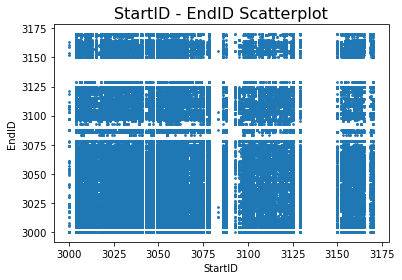

In [81]:

# schade, ich erkenne kein Muster :D
fig, scplot_ids = plt.subplots(nrows=1,ncols=1)
scplot_ids.scatter(df_bikes['start_station_id'],df_bikes['end_station_id'],s=3)
scplot_ids.set_title("StartID - EndID Scatterplot",fontsize=16)
scplot_ids.set_xlabel("StartID")
scplot_ids.set_ylabel("EndID")
#scplot_ids.show()

## KPI Utilization

In [82]:

#lists up all possible user types

#Note:
#Because we are working in 2021 with this dataset, some passes have changed. We got our Information
#from the official Indego Website so we derived that the 2017 user type 'Walk-up' is equivalent
#to the 2021 'Guest Pass'.
#Furthermore the user types 'IndegoFlex', 'OneDayPass' and 'TwoDayPass' do not exist any more in
#2021. Due to the low amount of loans of these user types we decided to drop them and focus on the
#more relevant user types which still exist and have significant more loans.

sumIndego30 = sum(1 for i in df_bikes["user_type"] if i == 'Indego30')
sumWalkUp = sum(1 for i in df_bikes["user_type"] if i == 'Walk-up')
sumIndegoFlex = sum(1 for i in df_bikes["user_type"] if i == 'IndegoFlex')
sumOneDayPass = sum(1 for i in df_bikes["user_type"] if i == 'One Day Pass')
sumTwoDayPass = sum(1 for i in df_bikes["user_type"] if i == 'Two Day Pass')
sumIndego365 = sum(1 for i in df_bikes["user_type"] if i == 'Indego365')


user_type_dict = {'Indego30': sumIndego30,
                  'WalkUp': sumWalkUp,
                  'IndegoFlex': sumIndegoFlex,
                  'OneDayPass': sumOneDayPass,
                  'TwoDayPass': sumTwoDayPass,
                  'Indego365': sumIndego365
                 }
user_type = pd.Series(user_type_dict)
user_type


Indego30      657214
WalkUp         86325
IndegoFlex      5520
OneDayPass      5765
TwoDayPass      1527
Indego365       6774
dtype: int64

In [83]:

#Wert müsste ungefähr passen. Laut Internetseite von Indego haben die seit 2019 1400 Fahrräder in der Flotte.

unique_bike_id = set(df_bikes['bike_id'])

print(len(unique_bike_id))

1250


In [84]:

#sums up the number of loans of one specific bike in the dataset within 2017 (type in bike ID)
def calc_unique_bike_amount_rides(v):
    unique_bike_amount_rides = sum(1 for i in df_bikes["bike_id"] if i == v)
    return print(unique_bike_amount_rides)

calc_unique_bike_amount_rides(2536)


594


In [85]:
#type in the parameters to get the utilization in % at this point of time
def utilization(year, month, day, hour, minute):
    point_of_time = datetime(year, month, day, hour, minute)
    df_smaller_pot = df_bikes[df_bikes["start_time"] < point_of_time]
    df_greater_pot = df_smaller_pot[df_smaller_pot["end_time"] > point_of_time]
    util = (len(df_greater_pot) / 1250) *100
    return util

utilization(2017, 1, 3, 12, 30)

1.04

In [86]:
#type in the parameters to get the percentage of available bikes at this point of time
def available_bikes(year, month, day, hour, minute):
    point_of_time = datetime(year, month, day, hour, minute)
    df_smaller_pot = df_bikes[df_bikes["start_time"] < point_of_time]
    df_greater_pot = df_smaller_pot[df_smaller_pot["end_time"] > point_of_time]
    avlbl = ((1250 - len(df_greater_pot)) / 1250) *100
    return avlbl

available_bikes(2017, 1, 3, 12, 30)

98.96000000000001

In [87]:

#creates an array containing the utilization of every minute within one hour
util_arr = []
for i in range(0, 59):
    util_arr.append(utilization(2017, 1, 3, 12, i))
print(max(util_arr))

1.3599999999999999


In [88]:
#sums up all loans for one entire day in 2017
def loans_per_day(month, day):
    day_in_2017_start = datetime(2017, month, day, 0, 0)
    day_in_2017_end = datetime(2017, month, day, 23, 59)
    df_day_start = df_bikes[df_bikes["start_time"] >= day_in_2017_start]
    df_day_end = df_day_start[df_day_start["start_time"] <= day_in_2017_end]
    return len(df_day_end)

loans_per_day(1, 26)

1397

In [89]:

#creates an array containing the total number of loans for one entire day for one month
month_arr = []
for i in range(1, 31):
    month_arr.append(loans_per_day(1, i))
print(month_arr)


[822, 1496, 1822, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1378, 597, 745, 992, 1015, 1471, 1590, 1212, 1175, 628, 513, 1084, 1639, 1397, 1317, 796, 783, 1248]


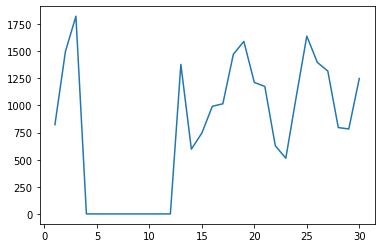

In [90]:

#total number of loans for one entire day for one month as lineplot
x = range(1, 31)
y = month_arr
plt.plot(x, y)

## KPI: Profit

In [91]:
#Notes:
# Prices from Indego's official website from 2021 for the user types OneDayPass, TwoDayPass, Indego30 and Indego365.
# For the user types Walk-up and IndegoFlex we took the official Indego prices for 2015. The price for Walk-up is 4$
# for every beginning 30 minutes. For IndegoFlex it is 4$ for every beginning 60 minutes.
# The four following mentioned calculations just contain the profit from overdrafts of the loans for user type OneDayPass
# (we assume that the 2021 Guest Pass is based on the user types OneDayPass and TwoDayPass - the cost for overtime are
# 15¢/minute for rides over 30 minutes) and the user types Indego30 and Indego365 (15¢/minute for rides over 60 minutes).
# Of course the biggest profit of OneDayPass, TwoDayPass, Indego30 and Indego 365 is made from selling passes but we do
# not have any information about the amount of sold passes so we focused on profit from overdrafts.


# profit from overtime loans of usertype OneDayPass

minutes30 = timedelta(minutes=30)

df_one_day = df_bikes[df_bikes['user_type'] == 'One Day Pass']
df_one_day_more_than_30_mins = df_one_day[df_one_day['duration'] > minutes30]
df_one_day_more_than_30_mins['overtime'] = df_one_day_more_than_30_mins['duration'] - minutes30

df_one_day_more_than_30_mins['costs_overtime'] = df_one_day_more_than_30_mins['overtime'].apply(lambda x: (x.total_seconds() / 60) * 0.15)

df_one_day_more_than_30_mins.head()

<ipython-input-91-20691185a29b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_day_more_than_30_mins['overtime'] = df_one_day_more_than_30_mins['duration'] - minutes30
<ipython-input-91-20691185a29b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_day_more_than_30_mins['costs_overtime'] = df_one_day_more_than_30_mins['overtime'].apply(lambda x: (x.total_seconds() / 60) * 0.15)


,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,weekday,is_weekday,overtime,costs_overtime
327848,2017-06-30 20:34:00,2017-06-30 21:40:00,3057,3045,2690,One Day Pass,Philadelphia Museum of Art,13th & Locust,0 days 01:06:00,4,1,0 days 00:36:00,5.40
328951,2017-07-01 12:39:00,2017-07-01 13:11:00,3074,3061,2588,One Day Pass,44th & Walnut,23rd & Market,0 days 00:32:00,5,0,0 days 00:02:00,0.30
329174,2017-07-01 14:11:00,2017-07-01 14:52:00,3050,3058,2682,One Day Pass,9th & Arch,20th & Fairmount,0 days 00:41:00,5,0,0 days 00:11:00,1.65
329237,2017-07-01 14:26:00,2017-07-01 15:25:00,3057,3108,11752,One Day Pass,Philadelphia Museum of Art,15th & Market,0 days 00:59:00,5,0,0 days 00:29:00,4.35
329242,2017-07-01 14:27:00,2017-07-01 15:25:00,3057,3108,3402,One Day Pass,Philadelphia Museum of Art,15th & Market,0 days 00:58:00,5,0,0 days 00:28:00,4.20


In [92]:
# total sum of all  overtime loans of usertype OneDayPass
sum_one_day_Overtime_Profit = sum(df_one_day_more_than_30_mins['costs_overtime'].apply(lambda x: x))
print(sum_one_day_Overtime_Profit)

1802.4000000000012


In [93]:
# profit from overtime loans of usertype TwoDayPass

df_two_day = df_bikes[df_bikes['user_type'] == 'Two Day Pass']
df_two_day_more_than_30_mins = df_two_day[df_two_day['duration'] > minutes30]
df_two_day_more_than_30_mins['overtime'] = df_two_day_more_than_30_mins['duration'] - minutes30

df_two_day_more_than_30_mins['costs_overtime'] = df_two_day_more_than_30_mins['overtime'].apply(lambda x: (x.total_seconds() / 60) * 0.15)

df_two_day_more_than_30_mins.head()

<ipython-input-93-243c10ce0e2b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_day_more_than_30_mins['overtime'] = df_two_day_more_than_30_mins['duration'] - minutes30
<ipython-input-93-243c10ce0e2b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_day_more_than_30_mins['costs_overtime'] = df_two_day_more_than_30_mins['overtime'].apply(lambda x: (x.total_seconds() / 60) * 0.15)


,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,weekday,is_weekday,overtime,costs_overtime
427254,2017-08-03 15:24:00,2017-08-03 16:04:00,3057,3101,11775,Two Day Pass,Philadelphia Museum of Art,11th & South,0 days 00:40:00,3,1,0 days 00:10:00,1.50
430322,2017-08-04 12:26:00,2017-08-04 12:57:00,3040,3046,3701,Two Day Pass,17th & Spring Garden,2nd & Market,0 days 00:31:00,4,1,0 days 00:01:00,0.15
430559,2017-08-04 13:49:00,2017-08-04 14:22:00,3026,3054,3507,Two Day Pass,2nd & South,Rodin Museum,0 days 00:33:00,4,1,0 days 00:03:00,0.45
430561,2017-08-04 13:50:00,2017-08-04 14:22:00,3026,3054,3531,Two Day Pass,2nd & South,Rodin Museum,0 days 00:32:00,4,1,0 days 00:02:00,0.30
431633,2017-08-04 18:08:00,2017-08-04 18:43:00,3156,3046,3572,Two Day Pass,20th & Market,2nd & Market,0 days 00:35:00,4,1,0 days 00:05:00,0.75


In [94]:
# total sum of all  overtime loans of usertype TwoDayPass
sum_two_day_Overtime_Profit = sum(df_two_day_more_than_30_mins['costs_overtime'].apply(lambda x: x))
print(sum_two_day_Overtime_Profit)


403.2000000000001


In [95]:
import math

# Calculation for user type 'Walk-up' based on the official 2015 prices of Indego. It costs 4$ every beginning 30 Minutes.

df_walk_up = df_bikes[df_bikes['user_type'] == 'Walk-up']
df_walk_up['duration_to_seconds'] = df_walk_up['duration'].apply(lambda x: x.total_seconds())
df_walk_up['price'] = df_walk_up['duration_to_seconds'].apply(lambda x: (int(math.ceil(x/1800)))*4)

#test
df_walk_up.head(5)

<ipython-input-95-67c4a338402f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_walk_up['duration_to_seconds'] = df_walk_up['duration'].apply(lambda x: x.total_seconds())
<ipython-input-95-67c4a338402f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_walk_up['price'] = df_walk_up['duration_to_seconds'].apply(lambda x: (int(math.ceil(x/1800)))*4)


,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,weekday,is_weekday,duration_to_seconds,price
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,0 days 00:36:00,6,0,2160.0,8
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,0 days 00:35:00,6,0,2100.0,8
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,0 days 00:08:00,6,0,480.0,4
5,2017-01-01 00:29:00,2017-01-01 00:36:00,3047,3124,2479,Walk-up,"Independence Mall, NPS",Race Street Pier,0 days 00:07:00,6,0,420.0,4
8,2017-01-01 00:38:00,2017-01-01 00:57:00,3013,3028,3716,Walk-up,6th & Fairmount,4th & Bainbridge,0 days 00:19:00,6,0,1140.0,4


In [96]:
# total sum of all Walk-up profits

sum_Walk_up_profit = sum(df_walk_up['price'].apply(lambda x: x))
print(sum_Walk_up_profit)


449888


In [97]:
# Calculation for user type 'IndegoFlex' based on the official 2015 prices of Indego. It costs 4$ every beginning 60 Minutes.

df_flex = df_bikes[df_bikes['user_type'] == 'IndegoFlex']
df_flex['duration_to_seconds'] = df_flex['duration'].apply(lambda x: x.total_seconds())
df_flex['price'] = df_flex['duration_to_seconds'].apply(lambda x: (int(math.ceil(x/3600)))*4)

#test
df_flex.head(5)

<ipython-input-97-9df66264aad5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flex['duration_to_seconds'] = df_flex['duration'].apply(lambda x: x.total_seconds())
<ipython-input-97-9df66264aad5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flex['price'] = df_flex['duration_to_seconds'].apply(lambda x: (int(math.ceil(x/3600)))*4)


,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,weekday,is_weekday,duration_to_seconds,price
190,2017-01-01 11:39:00,2017-01-01 11:44:00,3012,3114,3378,IndegoFlex,21st & Catharine,22nd & Federal,0 days 00:05:00,6,0,300.0,4
195,2017-01-01 11:42:00,2017-01-01 11:54:00,3054,3125,5182,IndegoFlex,Rodin Museum,15th & South,0 days 00:12:00,6,0,720.0,4
235,2017-01-01 12:26:00,2017-01-01 12:42:00,3037,3014,5214,IndegoFlex,Pennsylvania Convention Center,"21st & Winter, Franklin Institute",0 days 00:16:00,6,0,960.0,4
464,2017-01-01 15:22:00,2017-01-01 15:30:00,3068,3010,11009,IndegoFlex,Broad & Federal,15th & Spruce,0 days 00:08:00,6,0,480.0,4
625,2017-01-01 17:27:00,2017-01-01 17:49:00,3010,3099,3315,IndegoFlex,15th & Spruce,4th & Washington,0 days 00:22:00,6,0,1320.0,4


In [98]:
# total sum of all IndegoFlex profits

sum_flex_profit = sum(df_flex['price'].apply(lambda x: x))
print(sum_flex_profit)


22516


In [99]:
#profit from overtime loans of usertype Indego30
minutes60 = timedelta(minutes=60)

df_Indego30 = df_bikes[df_bikes["user_type"] == "Indego30"]
df_Indego30_more_than_60_mins = df_Indego30[df_Indego30["duration"] > minutes60]
df_Indego30_more_than_60_mins["overtime"] = df_Indego30_more_than_60_mins["duration"] - minutes60

df_Indego30_more_than_60_mins["costs_overtime"] = df_Indego30_more_than_60_mins["overtime"].apply(lambda x: (x.total_seconds() / 60) * 0.15)

df_Indego30_more_than_60_mins.head()

<ipython-input-99-c2d2a52ad31c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Indego30_more_than_60_mins["overtime"] = df_Indego30_more_than_60_mins["duration"] - minutes60
<ipython-input-99-c2d2a52ad31c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Indego30_more_than_60_mins["costs_overtime"] = df_Indego30_more_than_60_mins["overtime"].apply(lambda x: (x.total_seconds() / 60) * 0.15)


,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,weekday,is_weekday,overtime,costs_overtime
60,2017-01-01 02:52:00,2017-01-01 03:56:00,3059,3073,11042,Indego30,"Spring Garden Station, BSL",9th & Spring Garden,0 days 01:04:00,6,0,0 days 00:04:00,0.60
844,2017-01-01 22:31:00,2017-01-01 23:41:00,3067,3067,5144,Indego30,"39th & Mt. Vernon, Mantua Haverford Community ...","39th & Mt. Vernon, Mantua Haverford Community ...",0 days 01:10:00,6,0,0 days 00:10:00,1.50
1255,2017-03-01 06:48:00,2017-03-01 07:58:00,3032,3022,3645,Indego30,23rd & South,Amtrak 30th Street Station,0 days 01:10:00,2,1,0 days 00:10:00,1.50
1457,2017-03-01 12:51:00,2017-03-01 13:52:00,3068,3033,3556,Indego30,Broad & Federal,10th & Chestnut,0 days 01:01:00,2,1,0 days 00:01:00,0.15
2441,2017-04-01 12:29:00,2017-04-01 13:38:00,3078,3023,5291,Indego30,19th & Market,Rittenhouse Square,0 days 01:09:00,5,0,0 days 00:09:00,1.35


In [100]:
#total sum of all  overtime loans of usertype Indego30
sumIndego30OvertimeProfit = sum(df_Indego30_more_than_60_mins["costs_overtime"].apply(lambda x: x))
print(sumIndego30OvertimeProfit)

2035.6500000000005


In [101]:
#profit from overtime loans of usertype Indego365

df_Indego365 = df_bikes[df_bikes["user_type"] == "Indego365"]
df_Indego365_more_than_60_mins = df_Indego365[df_Indego365["duration"] > minutes60]
df_Indego365_more_than_60_mins["overtime"] = df_Indego365_more_than_60_mins["duration"] - minutes60

df_Indego365_more_than_60_mins["costs_overtime"] = df_Indego365_more_than_60_mins["overtime"].apply(lambda x: (x.total_seconds() / 60) * 0.15)

df_Indego365_more_than_60_mins.head()

<ipython-input-101-cddbfc7704ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Indego365_more_than_60_mins["overtime"] = df_Indego365_more_than_60_mins["duration"] - minutes60
<ipython-input-101-cddbfc7704ad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Indego365_more_than_60_mins["costs_overtime"] = df_Indego365_more_than_60_mins["overtime"].apply(lambda x: (x.total_seconds() / 60) * 0.15)


,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,weekday,is_weekday,overtime,costs_overtime
730681,2017-11-17 17:23:00,2017-11-17 18:31:00,3086,3037,11821,Indego365,Broad & Christian,Pennsylvania Convention Center,0 days 01:08:00,4,1,0 days 00:08:00,1.20
734250,2017-11-20 06:51:00,2017-11-20 08:00:00,3165,3161,3506,Indego365,24th & Race SRT,30th Street Station East,0 days 01:09:00,0,1,0 days 00:09:00,1.35
740289,2017-11-23 12:32:00,2017-11-23 13:34:00,3150,3150,11726,Indego365,"15th & Castle, DiSilvestro Playground","15th & Castle, DiSilvestro Playground",0 days 01:02:00,3,1,0 days 00:02:00,0.30
758225,2017-12-04 05:53:00,2017-12-04 06:54:00,3102,3161,2536,Indego365,Pennsylvania & Fairmount Perelman Building,30th Street Station East,0 days 01:01:00,0,1,0 days 00:01:00,0.15
758932,2017-12-04 12:10:00,2017-12-04 13:14:00,3129,3129,3288,Indego365,"The Children's Hospital of Philadelphia, Osler...","The Children's Hospital of Philadelphia, Osler...",0 days 01:04:00,0,1,0 days 00:04:00,0.60


In [102]:
#total sum of all  overtime loans of usertype Indego365
sumIndego365OvertimeProfit = sum(df_Indego365_more_than_60_mins["costs_overtime"].apply(lambda x: x))
print(sumIndego365OvertimeProfit)

7.95


In [103]:
# array containing all dates of the year
start_2017 = datetime(2017, 1, 1)
add_day = timedelta(days = 1)

days_2017 = []

for i in range(0, 365):
    days_2017.append(start_2017)
    start_2017 += add_day

print(days_2017)


[datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2017, 1, 2, 0, 0), datetime.datetime(2017, 1, 3, 0, 0), datetime.datetime(2017, 1, 4, 0, 0), datetime.datetime(2017, 1, 5, 0, 0), datetime.datetime(2017, 1, 6, 0, 0), datetime.datetime(2017, 1, 7, 0, 0), datetime.datetime(2017, 1, 8, 0, 0), datetime.datetime(2017, 1, 9, 0, 0), datetime.datetime(2017, 1, 10, 0, 0), datetime.datetime(2017, 1, 11, 0, 0), datetime.datetime(2017, 1, 12, 0, 0), datetime.datetime(2017, 1, 13, 0, 0), datetime.datetime(2017, 1, 14, 0, 0), datetime.datetime(2017, 1, 15, 0, 0), datetime.datetime(2017, 1, 16, 0, 0), datetime.datetime(2017, 1, 17, 0, 0), datetime.datetime(2017, 1, 18, 0, 0), datetime.datetime(2017, 1, 19, 0, 0), datetime.datetime(2017, 1, 20, 0, 0), datetime.datetime(2017, 1, 21, 0, 0), datetime.datetime(2017, 1, 22, 0, 0), datetime.datetime(2017, 1, 23, 0, 0), datetime.datetime(2017, 1, 24, 0, 0), datetime.datetime(2017, 1, 25, 0, 0), datetime.datetime(2017, 1, 26, 0, 0), datetime.datetime(20

In [104]:
# shows loans of every day - just for orientation

#create for every month in 2017 an array of the daily total amount of loans and then combine them
#in another array
days_28 = range(0, 28)
days_30 = range(0, 30)
days_31 = range(0, 31)

jan_loans = []
for i in range(1, 32):
    jan_loans.append(loans_per_day(1, i))
jan_Series = pd.Series(jan_loans, index=days_31)

feb_loans = []
for i in range(1, 29):
    feb_loans.append(loans_per_day(2, i))
feb_Series = pd.Series(feb_loans, index=days_28)

mar_loans = []
for i in range(1, 32):
    mar_loans.append(loans_per_day(3, i))
mar_Series = pd.Series(mar_loans, index=days_31)

apr_loans = []
for i in range(1, 31):
    apr_loans.append(loans_per_day(4, i))
apr_Series = pd.Series(apr_loans, index=days_30)

may_loans = []
for i in range(1, 32):
    may_loans.append(loans_per_day(5, i))
may_Series = pd.Series(may_loans, index=days_31)

jun_loans = []
for i in range(1, 31):
    jun_loans.append(loans_per_day(6, i))
jun_Series = pd.Series(jun_loans, index=days_30)

jul_loans = []
for i in range(1, 32):
    jul_loans.append(loans_per_day(7, i))
jul_Series = pd.Series(jul_loans, index=days_31)

aug_loans = []
for i in range(1, 32):
    aug_loans.append(loans_per_day(8, i))
aug_Series = pd.Series(aug_loans, index=days_31)

sep_loans = []
for i in range(1, 31):
    sep_loans.append(loans_per_day(9, i))
sep_Series = pd.Series(sep_loans, index=days_30)

oct_loans = []
for i in range(1, 32):
    oct_loans.append(loans_per_day(10, i))
oct_Series = pd.Series(oct_loans, index=days_31)

nov_loans = []
for i in range(1, 31):
    nov_loans.append(loans_per_day(11, i))
nov_Series = pd.Series(nov_loans, index=days_30)

dec_loans = []
for i in range(1, 32):
    dec_loans.append(loans_per_day(12, i))
dec_Series = pd.Series(dec_loans, index=days_31)

print(jan_Series.__len__(), feb_Series.__len__(), mar_Series.__len__(), apr_Series.__len__(),may_Series.__len__(), jun_Series.__len__(), jul_Series.__len__(), aug_Series.__len__(), sep_Series.__len__(), oct_Series.__len__(), nov_Series.__len__(), dec_Series.__len__())


31 28 31 30 31 30 31 31 30 31 30 31


In [105]:
days = range(0, 365)

days_Series = pd.Series(days_2017, index=days)
days_Series

0     2017-01-01
1     2017-01-02
2     2017-01-03
3     2017-01-04
4     2017-01-05
         ...    
360   2017-12-27
361   2017-12-28
362   2017-12-29
363   2017-12-30
364   2017-12-31
Length: 365, dtype: datetime64[ns]

In [123]:
# Calculate revenue for all 4 quarters: OneDayPass

qu1 = datetime(2017, 3, 31, 23, 59)
qu2 = datetime(2017, 6, 30, 23, 59)
qu3 = datetime(2017, 9, 30, 23, 59)
qu4 = datetime(2017, 12, 31, 23, 59)


qu1_OneDay = df_one_day_more_than_30_mins[df_one_day_more_than_30_mins["start_time"] <= qu1]
sum_Q1_OneDay = sum(qu1_OneDay["costs_overtime"].apply(lambda x: x))

qu2_OneDay = df_one_day_more_than_30_mins[df_one_day_more_than_30_mins["start_time"] > qu1]
qu2_OneDay_s = qu2_OneDay[qu2_OneDay["start_time"] <= qu2]
sum_Q2_OneDay = sum(qu2_OneDay_s["costs_overtime"].apply(lambda x: x))

qu3_OneDay = df_one_day_more_than_30_mins[df_one_day_more_than_30_mins["start_time"] > qu2]
qu3_OneDay_s = qu3_OneDay[qu3_OneDay["start_time"] <= qu3]
sum_Q3_OneDay = sum(qu3_OneDay_s["costs_overtime"].apply(lambda x: x))

qu4_OneDay = df_one_day_more_than_30_mins[df_one_day_more_than_30_mins["start_time"] > qu3]
sum_Q4_OneDay = sum(qu4_OneDay["costs_overtime"].apply(lambda x: x))

print(sum_Q1_OneDay + sum_Q2_OneDay + sum_Q3_OneDay + sum_Q4_OneDay)

1802.400000000001


,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,weekday,is_weekday,overtime,costs_overtime


In [162]:
# Calculate revenue for all 4 quarters: TwoDayPass

qu1_TwoDay = df_two_day_more_than_30_mins[df_two_day_more_than_30_mins["start_time"] <= qu1]
sum_Q1_TwoDay = sum(qu1_TwoDay["costs_overtime"].apply(lambda x: x))

qu2_TwoDay = df_two_day_more_than_30_mins[df_two_day_more_than_30_mins["start_time"] > qu1]
qu2_TwoDay_s = qu2_TwoDay[qu2_TwoDay["start_time"] <= qu2]
sum_Q2_TwoDay = sum(qu2_TwoDay_s["costs_overtime"].apply(lambda x: x))

qu3_TwoDay = df_two_day_more_than_30_mins[df_two_day_more_than_30_mins["start_time"] > qu2]
qu3_TwoDay_s = qu3_TwoDay[qu3_TwoDay["start_time"] <= qu3]
sum_Q3_TwoDay = sum(qu3_TwoDay_s["costs_overtime"].apply(lambda x: x))

qu4_TwoDay = df_two_day_more_than_30_mins[df_two_day_more_than_30_mins["start_time"] > qu3]
sum_Q4_TwoDay = sum(qu4_TwoDay["costs_overtime"].apply(lambda x: x))

print(sum_Q1_TwoDay + sum_Q2_TwoDay + sum_Q3_TwoDay + sum_Q4_TwoDay)

403.2000000000001
0 0 403.2000000000001 0


In [128]:
# Calculate revenue for all 4 quarters: Walk-up

qu1_WalkUp = df_walk_up[df_walk_up["start_time"] <= qu1]
sum_Q1_WalkUp = sum(qu1_WalkUp["price"].apply(lambda x: x))

qu2_WalkUp = df_walk_up[df_walk_up["start_time"] > qu1]
qu2_WalkUp_s = qu2_WalkUp[qu2_WalkUp["start_time"] <= qu2]
sum_Q2_WalkUp = sum(qu2_WalkUp_s["price"].apply(lambda x: x))

qu3_WalkUp = df_walk_up[df_walk_up["start_time"] > qu2]
qu3_WalkUp_s = qu3_WalkUp[qu3_WalkUp["start_time"] <= qu3]
sum_Q3_WalkUp = sum(qu3_WalkUp_s["price"].apply(lambda x: x))

qu4_WalkUp = df_walk_up[df_walk_up["start_time"] > qu3]
sum_Q4_WalkUp = sum(qu4_WalkUp["price"].apply(lambda x: x))

print(sum_Q1_WalkUp + sum_Q2_WalkUp + sum_Q3_WalkUp + sum_Q4_WalkUp)

449888


In [130]:
# Calculate revenue for all 4 quarters: IndegoFlex

qu1_flex = df_flex[df_flex["start_time"] <= qu1]
sum_Q1_flex = sum(qu1_flex["price"].apply(lambda x: x))

qu2_flex = df_flex[df_flex["start_time"] > qu1]
qu2_flex_s = qu2_flex[qu2_flex["start_time"] <= qu2]
sum_Q2_flex = sum(qu2_flex_s["price"].apply(lambda x: x))

qu3_flex = df_flex[df_flex["start_time"] > qu2]
qu3_flex_s = qu3_flex[qu3_flex["start_time"] <= qu3]
sum_Q3_flex = sum(qu3_flex_s["price"].apply(lambda x: x))

qu4_flex = df_flex[df_flex["start_time"] > qu3]
sum_Q4_flex = sum(qu4_flex["price"].apply(lambda x: x))

print(sum_Q1_flex + sum_Q2_flex + sum_Q3_flex + sum_Q4_flex)

22516


In [132]:
# Calculate revenue for all 4 quarters: Indego30

qu1_Indego30 = df_Indego30_more_than_60_mins[df_Indego30_more_than_60_mins["start_time"] <= qu1]
sum_Q1_Indego30 = sum(qu1_Indego30["costs_overtime"].apply(lambda x: x))

qu2_Indego30 = df_Indego30_more_than_60_mins[df_Indego30_more_than_60_mins["start_time"] > qu1]
qu2_Indego30_s = qu2_Indego30[qu2_Indego30["start_time"] <= qu2]
sum_Q2_Indego30 = sum(qu2_Indego30_s["costs_overtime"].apply(lambda x: x))

qu3_Indego30 = df_Indego30_more_than_60_mins[df_Indego30_more_than_60_mins["start_time"] > qu2]
qu3_Indego30_s = qu3_Indego30[qu3_Indego30["start_time"] <= qu3]
sum_Q3_Indego30 = sum(qu3_Indego30_s["costs_overtime"].apply(lambda x: x))

qu4_Indego30 = df_Indego30_more_than_60_mins[df_Indego30_more_than_60_mins["start_time"] > qu3]
sum_Q4_Indego30 = sum(qu4_Indego30["costs_overtime"].apply(lambda x: x))

print(sum_Q1_Indego30 + sum_Q2_Indego30 + sum_Q3_Indego30 + sum_Q4_Indego30)

2035.6499999999965


In [161]:
# Calculate revenue for all 4 quarters: Indego30

qu1_Indego365 = df_Indego365_more_than_60_mins[df_Indego365_more_than_60_mins["start_time"] <= qu1]
sum_Q1_Indego365 = sum(qu1_Indego365["costs_overtime"].apply(lambda x: x))

qu2_Indego365 = df_Indego365_more_than_60_mins[df_Indego365_more_than_60_mins["start_time"] > qu1]
qu2_Indego365_s = qu2_Indego365[qu2_Indego365["start_time"] <= qu2]
sum_Q2_Indego365 = sum(qu2_Indego365_s["costs_overtime"].apply(lambda x: x))

qu3_Indego365 = df_Indego365_more_than_60_mins[df_Indego365_more_than_60_mins["start_time"] > qu2]
qu3_Indego365_s = qu3_Indego365[qu3_Indego365["start_time"] <= qu3]
sum_Q3_Indego365 = sum(qu3_Indego365_s["costs_overtime"].apply(lambda x: x))

qu4_Indego365 = df_Indego365_more_than_60_mins[df_Indego365_more_than_60_mins["start_time"] > qu3]
sum_Q4_Indego365 = sum(qu4_Indego365["costs_overtime"].apply(lambda x: x))

print(sum_Q1_Indego365 + sum_Q2_Indego365 + sum_Q3_Indego365 + sum_Q4_Indego365)

7.95
0 0 0 7.95


Now we plot the quarters in pie charts

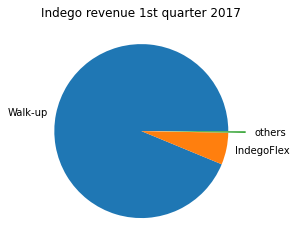

In [171]:
# 1st quarter

quarter1 = np.array([sum_Q1_WalkUp, sum_Q1_flex, sum_Q1_Indego30, sum_Q1_OneDay, sum_Q1_TwoDay, sum_Q1_Indego365])
ourlabels = ["Walk-up", "IndegoFlex", "others", " ", " ", " "]
ourexplode = [0, 0, 0.2, 0.2, 0.2, 0.2]

plt.pie(quarter1, labels=ourlabels, explode=ourexplode)
plt.title('Indego revenue 1st quarter 2017')
plt.show()

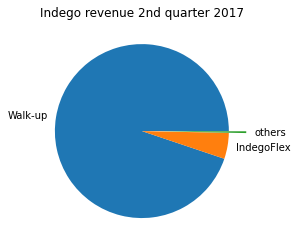

In [172]:
# 2nd quarter

quarter2 = np.array([sum_Q2_WalkUp, sum_Q2_flex, sum_Q2_Indego30, sum_Q2_OneDay, sum_Q2_TwoDay, sum_Q2_Indego365])

plt.pie(quarter2, labels=ourlabels, explode=ourexplode)
plt.title('Indego revenue 2nd quarter 2017')
plt.show()

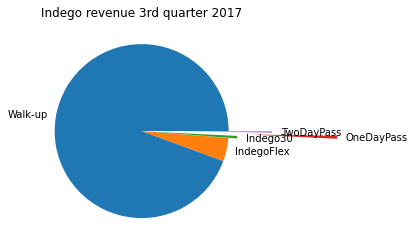

In [173]:
# 3rd quarter

quarter3 = np.array([sum_Q3_WalkUp, sum_Q3_flex, sum_Q3_Indego30, sum_Q3_OneDay, sum_Q3_TwoDay, sum_Q3_Indego365])
ourlabels2 = ["Walk-up", "IndegoFlex", "Indego30", "OneDayPass", "TwoDayPass", " "]
ourexplode2 = [0, 0, 0.1, 1.25, 0.5, 0.2]

plt.pie(quarter3, labels=ourlabels2, explode=ourexplode2)
plt.title('Indego revenue 3rd quarter 2017')
plt.show()

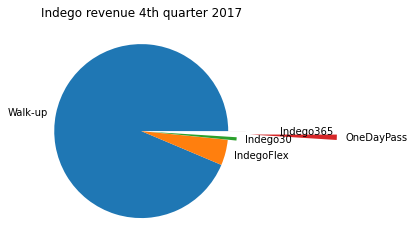

In [174]:
# 4th quarter

quarter4 = np.array([sum_Q4_WalkUp, sum_Q4_flex, sum_Q4_Indego30, sum_Q4_OneDay, sum_Q4_TwoDay, sum_Q4_Indego365])
ourlabels3 = ["Walk-up", "IndegoFlex", "Indego30", "OneDayPass", "Indego365", " "]

plt.pie(quarter4, labels=ourlabels3, explode=ourexplode2)
plt.title('Indego revenue 4th quarter 2017')
plt.show()